<a href="https://colab.research.google.com/github/Azimoj/Home-Credit-Default-Risk/blob/main/Model_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
plt.xkcd()

import gc
import time
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold

In [ ]:
import os
PATH = '/content/drive/MyDrive/p7/data/'
print(os.listdir(PATH))

['POS_CASH_balance.csv', 'application_test.csv', 'application_train.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'previous_application.csv', 'bureau.csv', 'bu_agg_final.csv', 'final_prev_df.csv', 'pos_agg_final.csv', 'ins_agg_final.csv', 'cc_agg_final.csv', 'bb_agg_final.csv', 'NEW_data_data.csv', 'X_scale_train.csv', 'X_train.csv', 'X_scale_test.csv', 'X_test.csv', 'result_XGB.csv', 'df_select_rf.csv', 'df_X_train_rf.csv', 'df_X_test_rf.csv', 'result_RF.csv', 'result_LightGBM.csv', 'X_train_final.csv', 'X_test_final.csv', 'y_test.csv', 'y_train.csv', 'LightGBM_impute_without_F0.csv', 'result_LightGBM_with_Feat0.csv', 'result_LightGBM_with_imput_F0.csv', 'result_LightGBM_with_imput_0F.csv', 'LightGBM_w_impute_without_0F.csv', 'result_LightGBM_wout_impute_w_0F.csv', 'result_LightGBM_wout_impute_0F.csv', 'Df_data.csv', 'data_clean.csv']


In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [ ]:
application_train = import_data(PATH+'application_train.csv')
application_test = import_data(PATH+'application_test.csv')

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 59.54 MB
Decreased by 79.2%
Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 9.40 MB
Decreased by 79.1%


In [ ]:
data = import_data(PATH+'NEW_data_data.csv')

Memory usage of dataframe is 1501.49 MB
Memory usage after optimization is: 384.46 MB
Decreased by 74.4%


**Spliting**

In [ ]:
data_clean = pd.read_csv('/content/drive/MyDrive/p7/data/data_clean.csv')

In [ ]:
data_clean.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,0.018800,...,32428.1170,194568.700,32426.280,32428.484,32428.1170,194568.70,-68.0,-123.3,-740.0,6.0
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,0.003542,...,6493.3286,233759.830,2705.760,19978.695,6493.3286,233759.83,-680.0,-1755.0,-63182.0,36.0
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,0.010030,...,5244.4540,73422.360,1346.400,5250.510,4494.3813,62921.34,-597.0,-742.0,-10390.0,14.0
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,0.008020,...,19638.8180,1080135.000,1.980,222195.920,18268.6720,1004776.94,-335.0,-1381.0,-75962.0,55.0
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,0.028660,...,5000.2650,55002.914,165.825,6761.835,3774.2727,41517.00,-602.0,-682.5,-7509.0,11.0


In [ ]:
data_clean.isnull().sum().sort_values(ascending=False)

SK_ID_CURR                                              0
PREV_NAME_GOODS_CATEGORY_Construction Materials_MEAN    0
PREV_NAME_CLIENT_TYPE_Refreshed_MEAN                    0
PREV_NAME_CLIENT_TYPE_Repeater_MEAN                     0
PREV_NAME_CLIENT_TYPE_nan_MEAN                          0
                                                       ..
ORGANIZATION_TYPE_Trade: type 6                         0
ORGANIZATION_TYPE_Trade: type 5                         0
ORGANIZATION_TYPE_Trade: type 4                         0
ORGANIZATION_TYPE_Trade: type 3                         0
INSTAL_COUNT                                            0
Length: 561, dtype: int64

In [ ]:
df= data_clean.drop('SK_ID_CURR', axis=1)


In [ ]:
X = df.drop('TARGET',axis=1)
y= df['TARGET']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X ,y,test_size = 0.3,random_state=0)
print('The shape of X_train is', X_train.shape)
print('The shape of X_test is', X_test.shape)
print('The shape of y_train is', y_train.shape)
print('The shape of y_test is', y_test.shape)

The shape of X_train is (215253, 559)
The shape of X_test is (92252, 559)
The shape of y_train is (215253,)
The shape of y_test is (92252,)


In [ ]:
from sklearn.preprocessing import StandardScaler
# StandardScaler
scaler_std = StandardScaler()

# Jeu d'entraînement du jeu d'entraînement
X_train_std = scaler_std.fit_transform(X_train.copy(deep=True))
# Jeu de validation du jeu d'entraînement
X_test_std = scaler_std.transform(X_test.copy(deep=True))


In [ ]:
del X,y,df

In [ ]:
import pickle

model = 'drive/MyDrive/p7/LGBM_wout_imput_wout_0F.sav'
pickle.load(open(model, 'rb'))

LGBMClassifier(boosting_type='goss', class_weight='balanced',
               n_estimators=10000, objective='binary')

### **Bayesian Optimization**

Bayesian optimization uses probability to find the minimum of a function. The final aim is to find the input value to a function which can gives us the lowest possible output value.It usually performs better than random,grid and manual search providing better performance in the testing phase and reduced optimization time. In Hyperopt, Bayesian Optimization can be implemented giving 3 three main parameters to the function fmin.

* Objective Function = defines the loss function to minimize.
* Domain Space = defines the range of input values to test (in Bayesian Optimization this space creates a probability distribution for each of the used Hyperparameters).
* Optimization Algorithm = defines the search algorithm to use to select the best input values to use in each new iteration.

https://github.com/krishnaik06/All-Hyperparamter-Optimization/blob/master/Hyper%20Parameter%20Optimization.ipynb

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from time import time

In [ ]:
space = {'colsample_bytree': hp.uniform('colsample_bytree', 0.8, 1),
          'learning_rate': hp.uniform('learning_rate', .01, .02), 
          'num_leaves': hp.choice('num_leaves', [33, 34, 35]), 
          'subsample': hp.uniform('subsample', 0.8, 1), 
          'max_depth': hp.choice('max_depth', [7, 8, 9]), 
          'reg_alpha': hp.uniform('reg_alpha', .03, .05), 
          'reg_lambda': hp.uniform('reg_lambda', .06, .08), 
          'min_split_gain': hp.uniform('min_split_gain', .01, .03),
          'min_child_weight': hp.choice('min_child_weight', [38, 39, 40])}

In [ ]:
space

{'colsample_bytree': <hyperopt.pyll.base.Apply at 0x7f3e529a3f50>,
 'learning_rate': <hyperopt.pyll.base.Apply at 0x7f3e529a3190>,
 'max_depth': <hyperopt.pyll.base.Apply at 0x7f3e529a5f10>,
 'min_child_weight': <hyperopt.pyll.base.Apply at 0x7f3e529b1810>,
 'min_split_gain': <hyperopt.pyll.base.Apply at 0x7f3e529b1490>,
 'num_leaves': <hyperopt.pyll.base.Apply at 0x7f3e529a3a10>,
 'reg_alpha': <hyperopt.pyll.base.Apply at 0x7f3e529b18d0>,
 'reg_lambda': <hyperopt.pyll.base.Apply at 0x7f3e529b19d0>,
 'subsample': <hyperopt.pyll.base.Apply at 0x7f3e529a5050>}

In [ ]:
def objective(space):
    model = LGBMClassifier( colsample_bytree = space['colsample_bytree'], 
                            learning_rate = space['learning_rate'],
                            num_leaves = space['num_leaves'],
                            subsample = space['subsample'],
                            max_depth = space['max_depth'],
                            reg_alpha = space['reg_alpha'],
                            reg_lambda = space['reg_lambda'],
                            min_split_gain = space['min_split_gain'],
                            min_child_weight = space['min_child_weight'], 
                            )
    
    accuracy = cross_val_score(model, X_train_std, y_train, cv = 5).mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }

In [32]:
from sklearn.model_selection import cross_val_score
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 80,
            trials= trials)
best

100%|██████████| 80/80 [5:31:01<00:00, 248.27s/it, best loss: -0.9189372506384468]


{'colsample_bytree': 0.8103547913406675,
 'learning_rate': 0.015769039457584174,
 'max_depth': 2,
 'min_child_weight': 2,
 'min_split_gain': 0.02754059104621516,
 'num_leaves': 1,
 'reg_alpha': 0.03127280419519087,
 'reg_lambda': 0.0619422432560838,
 'subsample': 0.801834021655345}

In [ ]:
from sklearn.model_selection import cross_val_score
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 80,
            trials= trials)
best

100%|██████████| 80/80 [5:37:30<00:00, 253.13s/it, best loss: -0.9189372506384468]


{'colsample_bytree': 0.897205838848013,
 'learning_rate': 0.01903391441841755,
 'max_depth': 1,
 'min_child_weight': 1,
 'min_split_gain': 0.023464913960387336,
 'num_leaves': 1,
 'reg_alpha': 0.03466317212004515,
 'reg_lambda': 0.06855724195516467,
 'subsample': 0.9904327467948528}

In [ ]:
num_leav = {0: 33, 1: 34, 2: 35,}
max_dep = {0: 7, 1: 8, 2: 9}
min_child_weight = {0: 38, 1: 39, 2: 40}


print(num_leav[best['num_leaves']])
print(max_dep[best['max_depth']])
print(min_child_weight[best['min_child_weight']])

34
8
39


In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

trainedLGBM = LGBMClassifier(colsample_bytree = best['colsample_bytree'], 
                            learning_rate = best['learning_rate'],
                            num_leaves = num_leav[best['num_leaves']],
                            subsample = best['subsample'],
                            max_depth = max_dep[best['max_depth']],
                            reg_alpha = best['reg_alpha'],
                            reg_lambda = best['reg_lambda'],
                            min_split_gain = best['min_split_gain'],
                            min_child_weight = min_child_weight[best['min_child_weight']],
                            boosting_type='goss', class_weight='balanced',
                            n_estimators=10000, objective='binary').fit(X_train,y_train)



In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

trainedLGBM = LGBMClassifier(colsample_bytree = 0.9, 
                            learning_rate = 0.02,
                            num_leaves = 34,
                            subsample = 0.1,
                            max_depth = 8,
                            reg_alpha = 0.035,
                            reg_lambda = 0.07,
                            min_split_gain = 0.024,
                            min_child_weight = 39,
                            boosting_type='goss', class_weight='balanced',
                            n_estimators=10000, objective='binary').fit(X_train,y_train)

In [35]:
predictionLGBM = trainedLGBM.predict(X_test)

In [36]:
print(confusion_matrix(y_test,predictionLGBM))
print("------------------")
print('Accuracy Score: ', accuracy_score(y_test,predictionLGBM))
print("------------------")
print(classification_report(y_test,predictionLGBM))
acc = accuracy_score(y_test,predictionLGBM)

[[75421  9455]
 [ 4654  2722]]
------------------
Accuracy Score:  0.8470602263365564
------------------
              precision    recall  f1-score   support

         0.0       0.94      0.89      0.91     84876
         1.0       0.22      0.37      0.28      7376

    accuracy                           0.85     92252
   macro avg       0.58      0.63      0.60     92252
weighted avg       0.88      0.85      0.86     92252



In [37]:
from sklearn.metrics import roc_auc_score
AUROC_LGBM_=roc_auc_score(y_test, predictionLGBM)
AUROC_LGBM_

0.628818451651658

In [40]:
prediction_LGBM = trainedLGBM.predict_proba(X_test)[:,1]

In [42]:
print(confusion_matrix(y_test,prediction_LGBM))
print("------------------")
print('Accuracy Score: ', accuracy_score(y_test,prediction_LGBM))
print("------------------")
print(classification_report(y_test,prediction_LGBM))
acc = accuracy_score(y_test,prediction_LGBM)

ValueError: ignored

In [44]:
import sklearn.metrics as me
y_predX = np.array(prediction_LGBM>0.15,dtype=int)
conf_mat = me.confusion_matrix(y_test, y_predX)
print(conf_mat)
print("------------------")
print('Accuracy Score: ', accuracy_score(y_test,prediction_LGBM))
print()
print(me.classification_report(y_test, y_predX))

[[42957 41919]
 [ 1462  5914]]
------------------


ValueError: ignored

In [45]:
AUROC_LGBM_=roc_auc_score(y_test, y_predX)
AUROC_LGBM_

0.6539521953117979

In [ ]:
AUROC_LGBM_=roc_auc_score(y_test, predictionLGBM)
AUROC_LGBM_

0.6196220926963607

In [ ]:
AUROC_LGBM_=roc_auc_score(y_test, predictionLGBM)
AUROC_LGBM_

0.7282185676585844

In [47]:
import pickle
best_model= trainedLGBM
pickle.dump(best_model, open('drive/MyDrive/p7/best_model.sav', 'wb'))

In [48]:
import pickle

pickle.load( open('drive/MyDrive/p7/best_model.sav', 'rb'))

LGBMClassifier(boosting_type='goss', class_weight='balanced',
               colsample_bytree=0.8103547913406675,
               learning_rate=0.015769039457584174, max_depth=9,
               min_child_weight=40, min_split_gain=0.02754059104621516,
               n_estimators=10000, num_leaves=34, objective='binary',
               reg_alpha=0.03127280419519087, reg_lambda=0.0619422432560838,
               subsample=0.801834021655345)

In [49]:
# Impact des features importance cumulées
feature_importance_values = best_model.feature_importances_
feature_names = list(X_train.columns)
feature_importances = pd.DataFrame({'feature': feature_names,
                                    'importance': feature_importance_values})


In [50]:
def plot_cumultative_feature_importance(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d variables nécessaires pour %0.2f de cummulative imortance' % (importance_index + 1, threshold))
    
    return df

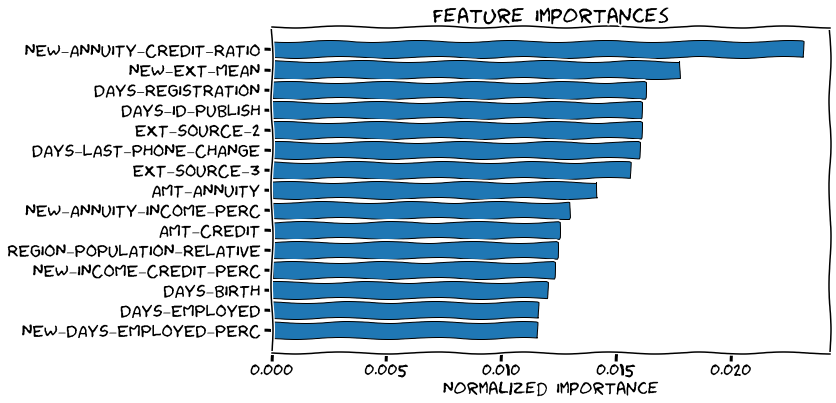

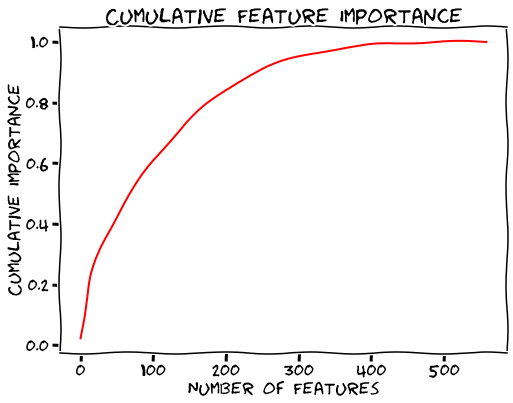

243 variables nécessaires pour 0.90 de cummulative imortance


In [51]:
# Show the feature importances for the new features
df_featimp = plot_cumultative_feature_importance(feature_importances)

In [54]:
# Make sure to average feature importances! 
feature_importances = best_model.feature_importances_
feature_importances = pd.DataFrame({'feature': list(X_train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head(10)

,feature,importance
70,NEW_ANNUITY_CREDIT_RATIO,7627
71,NEW_EXT_MEAN,5867
10,DAYS_REGISTRATION,5365
11,DAYS_ID_PUBLISH,5306
26,EXT_SOURCE_2,5297
35,DAYS_LAST_PHONE_CHANGE,5271
27,EXT_SOURCE_3,5140
6,AMT_ANNUITY,4676
69,NEW_ANNUITY_INCOME_PERC,4264
5,AMT_CREDIT,4120


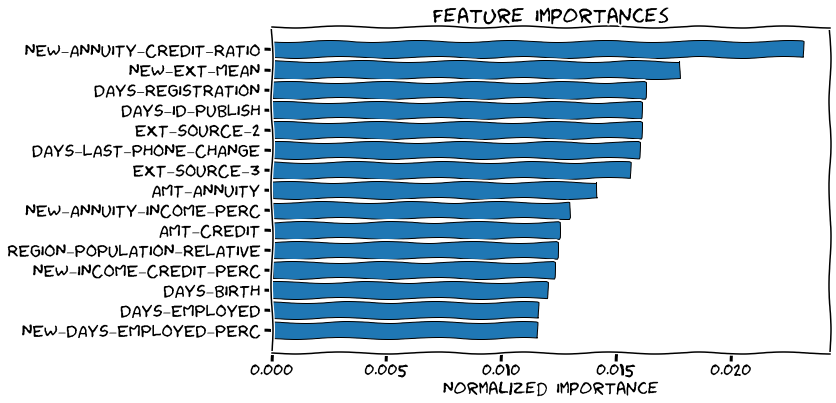

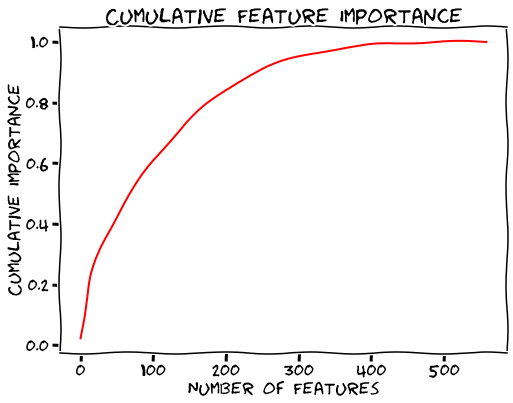

243 variables nécessaires pour 0.90 de cummulative imortance


In [58]:
# Impact des features importance cumulées
feature_importance_values = best_model.feature_importances_
feature_names = list(X_train.columns)
feature_importances = pd.DataFrame({'feature': feature_names,
                                    'importance': feature_importance_values})
# Show the feature importances for the new features
df_featimp = plot_cumultative_feature_importance(feature_importances)

In [55]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail(10)

There are 56 features with 0.0 importance


,feature,importance
158,ORGANIZATION_TYPE_Legal Services,0
102,NAME_FAMILY_STATUS_nan,0
154,ORGANIZATION_TYPE_Industry: type 8,0
273,CLOSED_CREDIT_DAY_OVERDUE_MAX,0
51,FLAG_DOCUMENT_17,0
274,CLOSED_CREDIT_DAY_OVERDUE_MEAN,0
53,FLAG_DOCUMENT_19,0
54,FLAG_DOCUMENT_20,0
55,FLAG_DOCUMENT_21,0
279,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,0


In [56]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """

    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
        # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

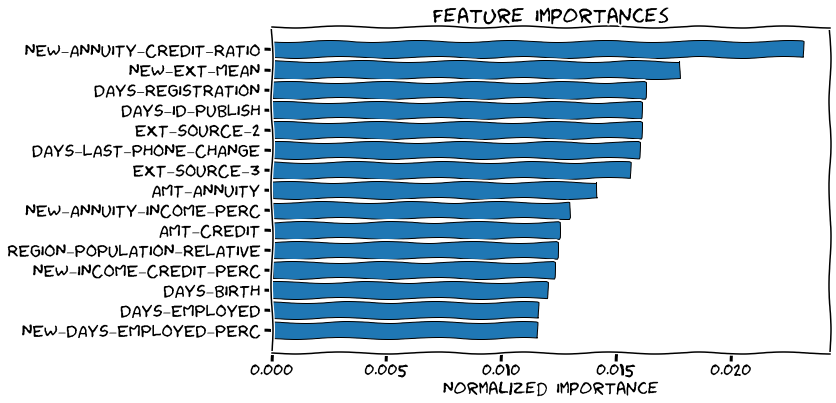

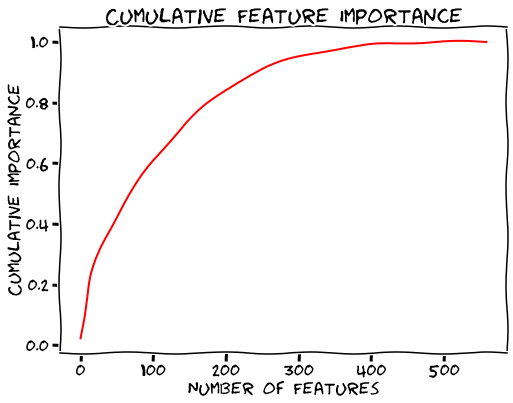

243 features required for 0.90 of cumulative importance


In [57]:
norm_feature_importances = plot_feature_importances(feature_importances)

## model interpretability **SHAP**
The SHAP method (SHapley Additive exPlanations) consists in calculating the Shapley value for all the variables of all the individuals, i.e. the average of the impact of a variable (on the output, therefore the prediction) for all possible combinations of variables.
The sum of the effects of each variable will explain the prediction.

In [ ]:
! pip install shap

In [ ]:
# Interprétation
import shap


In [ ]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
# Summary plot
shap.summary_plot(shap_values, X_test)

In [ ]:
import optuna
import sklearn.svm
def objective(trial):

    classifier = trial.suggest_categorical('classifier', ['RandomForest', 'SVC'])
    
    if classifier == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 200, 2000,10)
        max_depth = int(trial.suggest_float('max_depth', 10, 100, log=True))

        clf = sklearn.ensemble.RandomForestClassifier(
            n_estimators=n_estimators, max_depth=max_depth)
    else:
        c = trial.suggest_float('svc_c', 1e-10, 1e10, log=True)
        
        clf = sklearn.svm.SVC(C=c, gamma='auto')

    return sklearn.model_selection.cross_val_score(
        clf,X_train,y_train, n_jobs=-1, cv=3).mean()